In [1]:
# Imports

# System
import os
import sys
import PIL

# Processing
import numpy as np
from PIL import Image
from matplotlib import pyplot

# Keras
import tensorflow
from tensorflow import keras
from keras import Model, Input
from keras.layers import Dense, Dropout, Flatten, Reshape, Convolution2D, Convolution2DTranspose, BatchNormalization
from keras.preprocessing.image import img_to_array, array_to_img

tensorflow.executing_eagerly()

True

In [2]:
# Definitions

image_list = os.listdir("archive")[0:75]

train_list = image_list[0:40]
test_list = image_list[41:]

images = []
blurs = []

array_images = []
array_blurs = []

test_images = []
test_blurs = []
array_test_blurs = []

In [3]:
# Parameters

x = 128
y = 128
c = 3

map_size = 4

blur_x = 12
blur_y = 12

size = x * y * c

layer_1 = 16

In [4]:
# Preprocess Training

for i,v in enumerate(train_list):
	# Make images and blurs
    image = Image.open("./archive/" + v).convert("RGB").resize((x, y))
    blur = image.resize((blur_x, blur_y))
    #blur = blur.resize((x, y))

    images.append(image)
    blurs.append(blur)

    image_array = img_to_array(image, dtype=float)
    blur_array = img_to_array(blur, dtype=float)

    array_images.append(image_array)
    array_blurs.append(blur_array)


array_images = np.array(array_images) # List of np arrays
array_blurs = np.array(array_blurs) # List of np arrays

array_images /= 255 # Normalize values
array_blurs /= 255 # Normalize values

In [5]:
# Preprocess Testing

for i,v in enumerate(test_list):
	# Make images and blurs
    image = Image.open("./archive/" +  v).convert("RGB").resize((x, y))
    blur = image.resize((blur_x, blur_y))
    #blur = blur.resize((x, y))

    test_images.append(image)
    test_blurs.append(blur)

    blur_array = img_to_array(blur, dtype=float)
    array_test_blurs.append(blur_array)

array_test_blurs = np.array(array_blurs)

array_test_blurs /= 255 # Normalize values

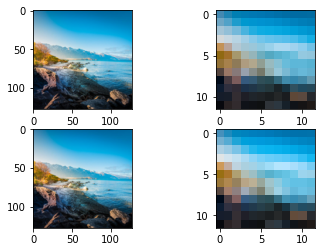

In [6]:
# Show Data

pyplot.subplot(221)
pyplot.imshow(images[15])
pyplot.subplot(222)
pyplot.imshow(blurs[15])

pyplot.subplot(223)
pyplot.imshow(array_to_img(array_images[15].reshape(x, y, c)))
pyplot.subplot(224)
pyplot.imshow(array_to_img(array_blurs[15].reshape(blur_x, blur_y, c)))
pyplot.show()

In [7]:
# Encoder

encoder_input = Input(shape=(blur_x, blur_y, c))

convo_0 = Convolution2D(6, (map_size, map_size), activation="sigmoid", padding="same")(encoder_input)
#convo_1 = Convolution2D(36, (map_size, map_size), activation="sigmoid", padding="same")(convo_0)

flatten = Flatten()(convo_0)
encoder_dense = Dense(layer_1)(flatten)
dropout = Dropout(0.1)(encoder_dense)

encoder = Model(encoder_input, dropout)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 12, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 12, 6)         294       
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                13840     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
Total params: 14,134
Trainable params: 14,134
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Decoder

decoder_input = Input(shape=(layer_1))

decoder_dense = Dense(x * y * 6)(decoder_input)
reshape = Reshape((x, y, 6))(decoder_dense)

#convoT_0 = Convolution2DTranspose(36, (map_size, map_size), activation="sigmoid", padding="same")(reshape)
convoT_1 = Convolution2DTranspose(6, (map_size, map_size), activation="relu", padding="same")(reshape)
convoT_2 = Convolution2DTranspose(3, (map_size, map_size), activation="sigmoid", padding="same")(convoT_1)

decoder = Model(decoder_input, convoT_2)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 98304)             1671168   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 6)       582       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 3)       291       
Total params: 1,672,041
Trainable params: 1,672,041
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model

image_input = Input(shape=(blur_x, blur_y, c))

model = Model(image_input, decoder(encoder(image_input)))

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12, 12, 3)]       0         
_________________________________________________________________
model (Functional)           (None, 16)                14134     
_________________________________________________________________
model_1 (Functional)         (None, 128, 128, 3)       1672041   
Total params: 1,686,175
Trainable params: 1,686,175
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train

model.fit(x=array_blurs, y=array_images, batch_size=32, epochs=128)

Epoch 1/128
2/2 [==============================] - 2s 81ms/step - loss: 0.0798
Epoch 2/128
2/2 [==============================] - 0s 126ms/step - loss: 0.0801
Epoch 3/128
2/2 [==============================] - 1s 121ms/step - loss: 0.0777
Epoch 4/128
2/2 [==============================] - 1s 105ms/step - loss: 0.0774
Epoch 5/128
2/2 [==============================] - 1s 109ms/step - loss: 0.0752
Epoch 6/128
2/2 [==============================] - 0s 79ms/step - loss: 0.0732
Epoch 7/128
2/2 [==============================] - 0s 101ms/step - loss: 0.0724
Epoch 8/128
2/2 [==============================] - 1s 125ms/step - loss: 0.0711
Epoch 9/128
2/2 [==============================] - 1s 126ms/step - loss: 0.0705
Epoch 10/128
2/2 [==============================] - 1s 128ms/step - loss: 0.0682
Epoch 11/128
2/2 [==============================] - 1s 119ms/step - loss: 0.0681
Epoch 12/128
2/2 [==============================] - 1s 109ms/step - loss: 0.0680
Epoch 13/128
2/2 [=====================

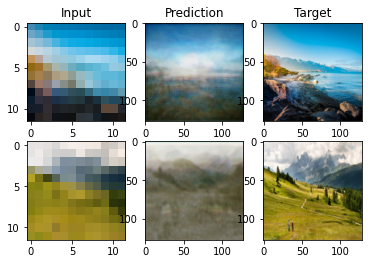

In [11]:
# Show Prediction Local

predictions = model.predict(array_blurs[15:17])
prediction_0 = predictions[0]
prediction_1 = predictions[1]

encodings = encoder.predict(array_blurs[15:17])
encoding_0 = encodings[0]
encoding_1 = encodings[1]

pyplot.subplot(231)
pyplot.title("Input")
pyplot.imshow(blurs[15])

pyplot.subplot(232)
pyplot.title("Prediction")
pyplot.imshow(prediction_0)

pyplot.subplot(233)
pyplot.title("Target")
pyplot.imshow(images[15])

# Show Prediction Local 2

pyplot.subplot(234)
pyplot.imshow(blurs[16])

pyplot.subplot(235)
pyplot.imshow(prediction_1)

pyplot.subplot(236)
pyplot.imshow(images[16])

pyplot.show()

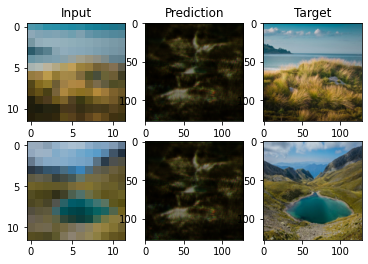

In [12]:
# Show Prediction

predictions = model.predict(array_test_blurs[14:16])
prediction_0 = predictions[0]
prediction_1 = predictions[1]

pyplot.subplot(231)
pyplot.title("Input")
pyplot.imshow(test_blurs[14])

pyplot.subplot(232)
pyplot.title("Prediction")
pyplot.imshow(prediction_0)

pyplot.subplot(233)
pyplot.title("Target")
pyplot.imshow(test_images[14])

# Show Prediction 2

pyplot.subplot(234)
pyplot.imshow(test_blurs[15])

pyplot.subplot(235)
pyplot.imshow(prediction_1)

pyplot.subplot(236)
pyplot.imshow(test_images[15])

pyplot.show()

In [13]:
model.save("./models/model_color_v2")

INFO:tensorflow:Assets written to: ./models/model_color_v2\assets
